In [1]:
import importlib
import pandas as pd
import numpy as np
import scipy.stats
from statsmodels.stats import multitest
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import math
import glob
import os

import sprawl
from sprawl import plotting, utils
import importlib

In [2]:
%%time
#this bam is from BICCN_10Xv3 has cell-type and sample of origin information as XO and RG tags respectively
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
    
#mouse gtf file to be able to plot exons/introns/UTRs
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/sprawl/inputs/gencode.vM23.annotation.gtf',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','end','dot1','strand','dot2','info'],
)
gtf = full_gtf[full_gtf['kind'].isin(['exon','UTR'])]
gtf['label'] = gtf['info'].str.extract('gene_name "(.*?)";')
gtf['group'] = gtf['info'].str.extract('transcript_id "(.*?)";')

#have to distinguish between 5' and 3' UTRs
for (transcript_id,strand),t in gtf.groupby(['group','strand']):
    if strand == '+':
        utr3_start = t[t['kind'].eq('exon')]['end'].max()
        utr_3s = t[t['kind'].eq('UTR') & t['end'].ge(utr3_start)]
    elif strand == '-':
        utr3_start = t[t['kind'].eq('exon')]['start'].min()
        utr_3s = t[t['kind'].eq('UTR') & t['start'].le(utr3_start)]
    else:
        sys.stderr.write('strand error\n')
        break
        
    gtf.loc[utr_3s.index,'kind'] = '3UTR'
        
gtf

CPU times: user 2min 29s, sys: 1.18 s, total: 2min 30s
Wall time: 2min 31s


,chrom,source,kind,start,end,dot1,strand,dot2,info,label,group
2,chr1,HAVANA,exon,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693.1""; transcript_id ...",4933401J01Rik,ENSMUST00000193812.1
5,chr1,ENSEMBL,exon,3102016,3102125,.,+,.,"gene_id ""ENSMUSG00000064842.1""; transcript_id ...",Gm26206,ENSMUST00000082908.1
8,chr1,HAVANA,exon,3213609,3216344,.,-,.,"gene_id ""ENSMUSG00000051951.5""; transcript_id ...",Xkr4,ENSMUST00000162897.1
9,chr1,HAVANA,exon,3205901,3207317,.,-,.,"gene_id ""ENSMUSG00000051951.5""; transcript_id ...",Xkr4,ENSMUST00000162897.1
11,chr1,HAVANA,exon,3213439,3215632,.,-,.,"gene_id ""ENSMUSG00000051951.5""; transcript_id ...",Xkr4,ENSMUST00000159265.1
...,...,...,...,...,...,...,...,...,...,...,...
1868189,chrM,ENSEMBL,3UTR,13552,13554,.,-,.,"gene_id ""ENSMUSG00000064368.1""; transcript_id ...",mt-Nd6,ENSMUST00000082419.1
1868192,chrM,ENSEMBL,exon,14071,14139,.,-,.,"gene_id ""ENSMUSG00000064369.1""; transcript_id ...",mt-Te,ENSMUST00000082420.1
1868195,chrM,ENSEMBL,exon,14145,15288,.,+,.,"gene_id ""ENSMUSG00000064370.1""; transcript_id ...",mt-Cytb,ENSMUST00000082421.1
1868200,chrM,ENSEMBL,exon,15289,15355,.,+,.,"gene_id ""ENSMUSG00000064371.1""; transcript_id ...",mt-Tt,ENSMUST00000082422.1


In [3]:
genes = {'Asic4','Slc32a1','Nr2f2'}

loci = gtf[
    gtf['label'].isin(genes) &
    gtf['kind'].eq('3UTR')
][['label','chrom','start','end','strand']].drop_duplicates()

loci = loci.groupby(['label','chrom','strand']).agg(
    start = ('start','min'),
    end = ('end','max'),
).reset_index()

loci

,label,chrom,strand,start,end
0,Asic4,chr1,+,75473630,75474343
1,Nr2f2,chr7,-,70351944,70354659
2,Slc32a1,chr2,+,158615002,158615748


In [4]:
importlib.reload(utils)

pos_df = pd.DataFrame()

for i,r in loci.iterrows():
    locus = (r.chrom, r.start, r.end)
    gene_pos_df = utils.bam_read_positions(bam_path, locus, stratify_tag='XO')
    gene_pos_df['gene'] = r.label
    pos_df = pd.concat((pos_df, gene_pos_df))

pos_df

,strat,pos,gene
0,L5_IT,75473630,Asic4
1,L23_IT,75473632,Asic4
2,L5_IT,75473632,Asic4
3,L23_IT,75473632,Asic4
4,L5_IT,75473633,Asic4
...,...,...,...
65000,L5_IT,158615732,Slc32a1
65001,Lamp5,158615732,Slc32a1
65002,Lamp5,158615738,Slc32a1
65003,Lamp5,158615741,Slc32a1


In [1]:
# create bedGraph file for each gene/cell-type
#track type=bedGraph name="BedGraph Format" description="BedGraph format" visibility=full color=200,100,0 altColor=0,100,200 priority=20
#chr19 49302000 49302300 -1.0
#chr19 49302300 49302600 -0.75
#chr19 49302600 49302900 -0.50

bin_size = 50

for i,r in loci.iterrows():
    gene = r.label
    chrom,min_val,max_val = r.chrom, r.start, r.end
    
    span = max_val-min_val
    padding = int(span*0.2) #pad by 20%
    min_val -= padding
    max_val += padding

    bedgraph_df = pos_df[pos_df['pos'].between(min_val,max_val) & pos_df['gene'].eq(gene)]

    bins = np.arange(min_val,max_val,bin_size)
    bin_labels = pd.Categorical(bins[:-1])

    bedgraph_df['bin'] = pd.cut(bedgraph_df['pos'], bins=bins)
    bedgraph_df = bedgraph_df.dropna()

    for i,(ont,g) in enumerate(bedgraph_df.groupby('strat')):
        if ont in {'Low_Quality','doublet'}:
            continue

        bin_counts = g.groupby('bin')['pos'].count().fillna(0)
        
        #skip ontologies with too few reads
        if bin_counts.sum() < 100:
            continue
            
        out_path = 'bedGraphs/{}_{}.bedGraph'.format(gene,ont).replace(' ','_')

        with open(out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="{}" visibility=full maxHeightPixels=50 graphType=bar\n'.format(ont))

        density_df = bin_counts.reset_index()
        density_df['chr'] = chrom
        density_df['left'] = density_df['bin'].apply(lambda v: v.left)
        density_df['right'] = density_df['bin'].apply(lambda v: v.right)
        density_df[['chr','left','right','pos']].to_csv(out_path, mode='a', header=None, sep=' ', index=None)


NameError: name 'loci' is not defined

# Make cell plots for the genes

Finding highly/lowly central cells for Asic4

Finding highly/lowly punctate cells for Slc32a1

In [7]:
gene_cell = pd.read_csv(
    '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/BICCN_mouse1_central_gene_cell.csv',
)

asic_cells = gene_cell[
    gene_cell['gene'].eq('Asic4')
    & gene_cell['num_gene_spots'].ge(10)
]

display(asic_cells[asic_cells['annotation'].eq('L6_IT')].sort_values('score'))

display(asic_cells[asic_cells['annotation'].eq('L23_IT')].sort_values('score'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
2200453,central,336646529642055267768959348109652160850,L6_IT,628,Asic4,11,-0.754386,0.075938,BICCN_mouse1,m1s3
2951670,central,14000269404966137018041373963996275943,L6_IT,874,Asic4,13,-0.718213,0.065901,BICCN_mouse1,m1s4
3209280,central,274656920125352761090560635572118210276,L6_IT,1067,Asic4,10,-0.633208,0.075259,BICCN_mouse1,m1s4
3881197,central,282912095966128680201069669881416490403,L6_IT,767,Asic4,12,-0.633159,0.065157,BICCN_mouse1,m1s4
4730725,central,311893110363546309012516788764825169789,L6_IT,759,Asic4,11,-0.609499,0.076109,BICCN_mouse1,m1s5
...,...,...,...,...,...,...,...,...,...,...
5710617,central,133507166853760950991966357127737616195,L6_IT,623,Asic4,16,0.389068,0.051191,BICCN_mouse1,m1s6
1420310,central,105455034922718568535873736830834169279,L6_IT,795,Asic4,13,0.498741,0.065824,BICCN_mouse1,m1s2
2352885,central,92155149478037940885613698858244027516,L6_IT,481,Asic4,11,0.566667,0.075634,BICCN_mouse1,m1s3
2138870,central,149782381946256799105261801090416930249,L6_IT,586,Asic4,10,0.623932,0.074847,BICCN_mouse1,m1s3


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
4547671,central,288797999873228368334054327171498932079,L23_IT,600,Asic4,10,-0.742905,0.074868,BICCN_mouse1,m1s5
577501,central,306679507182522087343877408704890491017,L23_IT,919,Asic4,11,-0.281046,0.076251,BICCN_mouse1,m1s1
116019,central,139074951638835036178375157757807325824,L23_IT,801,Asic4,11,-0.057500,0.076151,BICCN_mouse1,m1s1
1060836,central,141554055360048738901163612418068533332,L23_IT,876,Asic4,12,0.014857,0.065254,BICCN_mouse1,m1s2
378751,central,25011692670067243196435733417237266047,L23_IT,293,Asic4,14,0.441781,0.056118,BICCN_mouse1,m1s1


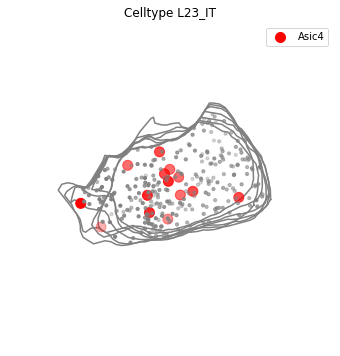

In [8]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample1.hdf5')
cell = sample.get_cells_by_id(['25011692670067243196435733417237266047'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Asic4':'red'})
ax.view_init(elev=90)
plt.savefig('cell_plots/asic4_L23_IT.svg')
plt.show(fig)
plt.close()

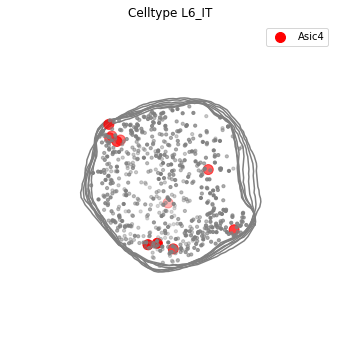

In [9]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample3.hdf5')
cell = sample.get_cells_by_id(['336646529642055267768959348109652160850'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Asic4':'red'})
ax.view_init(elev=90)
plt.savefig('cell_plots/asic4_L6_IT.svg')
plt.show(fig)
plt.close()

In [15]:
#Slc32a1
gene_cell = pd.read_csv(
    '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/BICCN_mouse1_punctate_gene_cell.csv',
)

slc_cells = gene_cell[
    gene_cell['gene'].eq('Slc32a1')
    & gene_cell['num_gene_spots'].ge(10)
]

display(slc_cells[slc_cells['annotation'].eq('Lamp5')].sort_values('score'))

display(slc_cells[slc_cells['annotation'].eq('L23_IT')].sort_values('score'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
1988456,puncta,274251767654866697316162245864521686971,Lamp5,702,Slc32a1,24,-1.000,0.334,BICCN_mouse1,m1s4
2106902,puncta,209942030807997832777557727785386253063,Lamp5,373,Slc32a1,30,-1.000,0.334,BICCN_mouse1,m1s4
3685855,puncta,293786932445281924407352152648736221029,Lamp5,848,Slc32a1,31,-0.998,0.334,BICCN_mouse1,m1s5
3099201,puncta,224236523439270703100209403965010064459,Lamp5,198,Slc32a1,12,-0.996,0.334,BICCN_mouse1,m1s5
3246741,puncta,48151710992266430676194160437123975977,Lamp5,332,Slc32a1,25,-0.996,0.334,BICCN_mouse1,m1s5
...,...,...,...,...,...,...,...,...,...,...
2366722,puncta,164147803831760976252575454532675943577,Lamp5,709,Slc32a1,35,0.998,0.334,BICCN_mouse1,m1s4
892652,puncta,240910632286248586906428634957985933851,Lamp5,366,Slc32a1,29,0.998,0.334,BICCN_mouse1,m1s2
310919,puncta,302326516346019454911760055190680904297,Lamp5,346,Slc32a1,27,1.000,0.334,BICCN_mouse1,m1s1
157076,puncta,36082235911494963883996801803576862007,Lamp5,296,Slc32a1,16,1.000,0.334,BICCN_mouse1,m1s1


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
554108,puncta,108099640095534731626013369960240551545,L23_IT,839,Slc32a1,10,-0.036,0.334,BICCN_mouse1,m1s2
2785606,puncta,151848663928328085783945597154139538810,L23_IT,752,Slc32a1,12,0.544,0.334,BICCN_mouse1,m1s6
244792,puncta,306229575665294799688274139604728274758,L23_IT,723,Slc32a1,12,0.984,0.334,BICCN_mouse1,m1s1
1182365,puncta,157076161725115238835692129035173421406,L23_IT,977,Slc32a1,12,1.000,0.334,BICCN_mouse1,m1s2


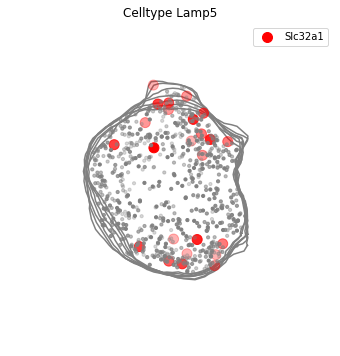

In [11]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample4.hdf5')
cell = sample.get_cells_by_id(['274251767654866697316162245864521686971'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Slc32a1':'red'})
ax.view_init(elev=90)
plt.savefig('cell_plots/slc32a1_lamp5.svg')
plt.show(fig)
plt.close()

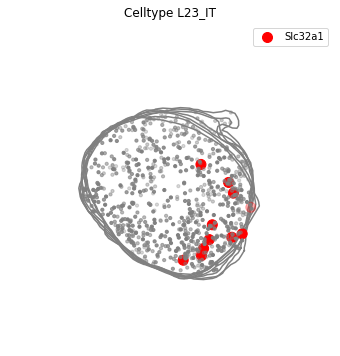

In [12]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample1.hdf5')
cell = sample.get_cells_by_id(['306229575665294799688274139604728274758'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Slc32a1':'red'})
ax.view_init(elev=90)
plt.savefig('cell_plots/slc32a1_l23.svg')
plt.show(fig)
plt.close()

In [18]:
#Nr2f2
gene_cell = pd.read_csv(
    '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/BICCN_mouse1_radial_gene_cell.csv',
)

cells = gene_cell[
    gene_cell['gene'].eq('Nr2f2')
    & gene_cell['num_gene_spots'].ge(10)
]

display(cells[cells['annotation'].eq('L6_IT_Car3')].sort_values('score'))

display(cells[cells['annotation'].eq('Sst')].sort_values('score'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
582651,radial,25219432518548007652476229632422618622,L6_IT_Car3,504,Nr2f2,10,-0.998,0.334,BICCN_mouse1,m1s3
1552568,radial,7786660251098883369725686535669998310,L6_IT_Car3,1444,Nr2f2,33,-0.996,0.334,BICCN_mouse1,m1s2
502685,radial,149871039313588834699052726136689204337,L6_IT_Car3,780,Nr2f2,13,-0.984,0.334,BICCN_mouse1,m1s3
3147281,radial,32363498529678243438894603247452162483,L6_IT_Car3,535,Nr2f2,17,-0.976,0.334,BICCN_mouse1,m1s4
593759,radial,275353458010555022895475418547983811245,L6_IT_Car3,519,Nr2f2,12,-0.974,0.334,BICCN_mouse1,m1s3
...,...,...,...,...,...,...,...,...,...,...
1391760,radial,152392852735467441545080155644756819033,L6_IT_Car3,543,Nr2f2,10,0.994,0.334,BICCN_mouse1,m1s2
3381871,radial,225887601058678055986418757762717949432,L6_IT_Car3,1400,Nr2f2,26,0.994,0.334,BICCN_mouse1,m1s4
3810698,radial,299918269843072894568297711902396922722,L6_IT_Car3,364,Nr2f2,10,0.994,0.334,BICCN_mouse1,m1s4
917621,radial,804083287060431541646983329419679067,L6_IT_Car3,1085,Nr2f2,10,0.996,0.334,BICCN_mouse1,m1s2


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
2971111,radial,65834913339359961135451503206371721659,Sst,628,Nr2f2,20,-0.998,0.334,BICCN_mouse1,m1s6
1148540,radial,159529815327904355234433890290002014638,Sst,674,Nr2f2,12,-0.982,0.334,BICCN_mouse1,m1s2
576343,radial,110732520685786005040422925683843211830,Sst,503,Nr2f2,11,-0.966,0.334,BICCN_mouse1,m1s3
2453796,radial,302540216813726727162852548580047990845,Sst,517,Nr2f2,12,-0.942,0.334,BICCN_mouse1,m1s5
1740634,radial,45532866656433865472764650538054484560,Sst,517,Nr2f2,12,-0.942,0.334,BICCN_mouse1,m1s5
...,...,...,...,...,...,...,...,...,...,...
1490744,radial,129171782913180423067739312614433749407,Sst,180,Nr2f2,10,0.964,0.334,BICCN_mouse1,m1s2
2047522,radial,295954576229765667698493147448290430519,Sst,571,Nr2f2,12,0.974,0.334,BICCN_mouse1,m1s5
3828171,radial,14802146437961127865454119232440845381,Sst,1523,Nr2f2,17,0.974,0.334,BICCN_mouse1,m1s4
991026,radial,14107424799301884758913722778950898184,Sst,764,Nr2f2,14,0.988,0.334,BICCN_mouse1,m1s2


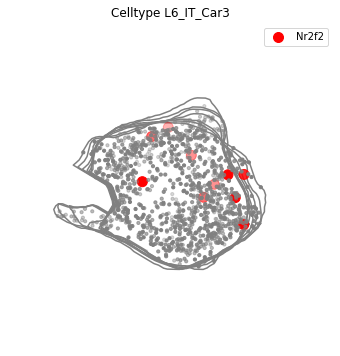

In [21]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample2.hdf5')
cell = sample.get_cells_by_id(['804083287060431541646983329419679067'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Nr2f2':'red'})
ax.view_init(elev=90)
plt.savefig('cell_plots/Nr2f2_L6_IT_Car3.svg')
plt.show(fig)
plt.close()

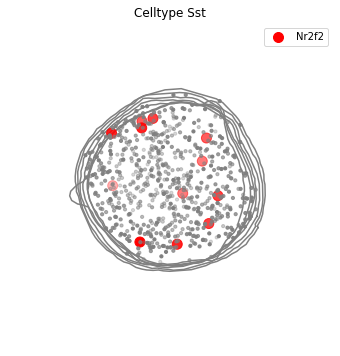

In [22]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample2.hdf5')
cell = sample.get_cells_by_id(['159529815327904355234433890290002014638'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Nr2f2':'red'})
ax.view_init(elev=90)
plt.savefig('cell_plots/Nr2f2_sst.svg')
plt.show(fig)
plt.close()